## Model Comparison

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
import warnings

from scipy.special import expit

%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

## Question 1

This exercise is about regularization priors. In the code that generates the data, change order=2 to another value, such as order=5. Then, fit model_p and plot the resulting curve. Repeat this, but now using a prior for beta with sd=100 instead of sd=1 and plot the resulting curve. How are both curves different? Try this out with `sd=np.array([10, 0.1, 0.1, 0.1, 0.1])`, too.

<p><font color="blue">
    <p>Increasing SD of beta from 1 to 100 seems to have no effect on the predicted values. Setting an array where the linear part has higher SD (10) compared to the others results in a curve that seems to have a worse fit.</p>
</font></p>    

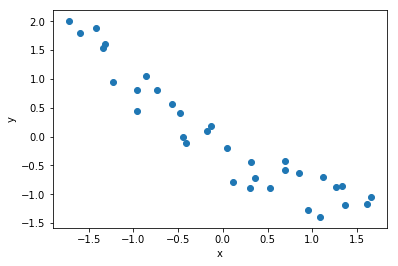

In [3]:
dummy_data = np.loadtxt('../BAP/code/data/dummy.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]
order = 5

x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()

plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y')
_ = plt.show()

In [4]:
with pm.Model() as model_p_q1a:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, x_1s)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    trace_p_q1a = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:31<00:00, 317.04draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [5]:
az.summary(trace_p_q1a)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,-0.00,0.05,0.00,-0.10,0.09,6055.0,1.0
β[0],-1.41,0.14,0.00,-1.68,-1.16,5506.0,1.0
β[1],0.28,0.42,0.00,-0.53,1.05,4398.0,1.0
β[2],0.27,0.71,0.01,-1.03,1.67,4495.0,1.0
β[3],0.13,0.81,0.01,-1.40,1.68,3481.0,1.0
β[4],-0.16,0.55,0.01,-1.18,0.89,3673.0,1.0
ϵ,0.28,0.04,0.00,0.21,0.35,5264.0,1.0


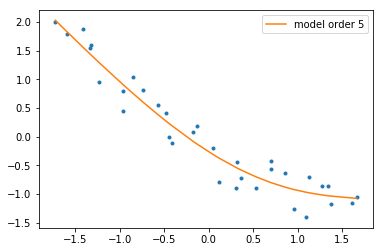

In [6]:
α_p_post = trace_p_q1a['α'].mean()
β_p_post = trace_p_q1a['β'].mean(axis=0)

idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], 'C1', label=f'model order {order}')
plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend(loc="best")
_ = plt.show()

In [7]:
with pm.Model() as model_p_q1b:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=100, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, x_1s)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    trace_p_q1b = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains: 100%|██████████| 10000/10000 [02:18<00:00, 72.13draws/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [8]:
az.summary(trace_p_q1b)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,0.00,0.05,0.00,-0.10,0.09,5024.0,1.0
β[0],-1.44,0.29,0.00,-1.97,-0.87,2197.0,1.0
β[1],0.24,0.67,0.01,-1.01,1.50,4659.0,1.0
β[2],0.30,3.11,0.04,-5.56,6.04,1974.0,1.0
β[3],0.41,5.39,0.06,-9.60,10.70,1930.0,1.0
β[4],-0.40,2.75,0.03,-5.41,4.97,2042.0,1.0
ϵ,0.29,0.04,0.00,0.22,0.36,4011.0,1.0


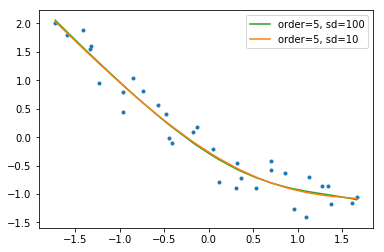

In [9]:
α_p_post = trace_p_q1b['α'].mean()
β_p_post = trace_p_q1b['β'].mean(axis=0)

y_p_sd100_post = α_p_post + np.dot(β_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_sd100_post[idx], 'C2', label=f'order={order}, sd=100')
plt.plot(x_1s[0][idx], y_p_post[idx], 'C1', label=f'order={order}, sd=10')
plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend(loc="best")
_ = plt.show()

In [10]:
with pm.Model() as model_p_q1c:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=np.array([10, 0.1, 0.1, 0.1, 0.1]))
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, x_1s)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    trace_p_q1c = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:03<00:00, 2754.23draws/s]
The acceptance probability does not match the target. It is 0.888843654168001, but should be close to 0.8. Try to increase the number of tuning steps.


In [11]:
az.summary(trace_p_q1c)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,0.00,0.07,0.0,-0.12,0.12,8371.0,1.0
β,-0.27,0.04,0.0,-0.35,-0.18,5534.0,1.0
ϵ,0.84,0.05,0.0,0.75,0.94,5674.0,1.0


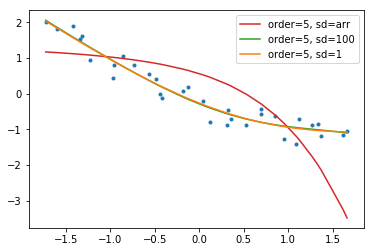

In [12]:
α_p_post = trace_p_q1c['α'].mean()
β_p_post = trace_p_q1c['β'].mean(axis=0)
β_p_post = np.array([β_p_post] * 5).T

y_p_sdarr_post = α_p_post + np.dot(β_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_sdarr_post[idx], 'C3', label=f'order={order}, sd=arr')
plt.plot(x_1s[0][idx], y_p_sd100_post[idx], 'C2', label=f'order={order}, sd=100')
plt.plot(x_1s[0][idx], y_p_post[idx], 'C1', label=f'order={order}, sd=1')
plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend(loc="best")
_ = plt.show()

100%|██████████| 200/200 [00:00<00:00, 1212.73it/s]


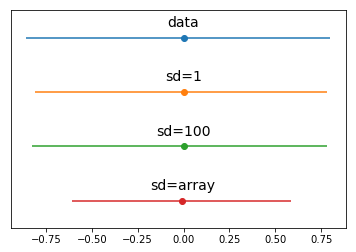

In [13]:
y_q1a_pps = pm.sample_posterior_predictive(trace_p_q1a, 200, model=model_p_q1a)['y_pred']
y_q1b_pps = pm.sample_posterior_predictive(trace_p_q1b, 200, model=model_p_q1b)['y_pred']
y_q1c_pps = pm.sample_posterior_predictive(trace_p_q1c, 200, model=model_p_q1c)['y_pred']

data = [y_1s, y_q1a_pps, y_q1b_pps, y_q1c_pps]
labels = ['data', 'sd=1', 'sd=100', 'sd=array']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)

plt.ylim([-i-0.5, 0.5])
plt.yticks([])
_ = plt.show()

## Question 2

Repeat the previous exercise but increase the amount of data to 500 data points.

In [14]:
coeffs = np.random.sample(size=6).reshape(-1, 1)
xmin, xmax = np.min(dummy_data[:, 0]), np.max(dummy_data[:, 0])
noise = 500 * np.random.sample(size=500)
xs = xmin + (xmax - xmin) * np.random.sample(size=500).reshape(1, -1)
X = np.vstack((xs**0, xs**1, xs**2, xs**3, xs**4, xs**5)).T

y = (np.dot(X, coeffs)).reshape((-1,)) + noise
Xr = X[:, 1:].T
x = X[:, 1]

coeffs.shape, X.shape, Xr.shape, x.shape, y.shape

((6, 1), (500, 6), (5, 500), (500,), (500,))

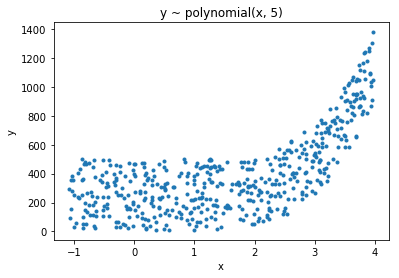

In [15]:
plt.scatter(x, y, c='C0', marker='.')
plt.xlabel("x")
plt.ylabel("y")
plt.title("y ~ polynomial(x, 5)")
_ = plt.show()

In [16]:
with pm.Model() as model_p_q2a:
    α = pm.Normal('α', mu=0, sd=1)    
    β = pm.Normal('β', mu=0, sd=1, shape=5)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, Xr)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_p_q2a = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:29<00:00, 333.61draws/s]
The acceptance probability does not match the target. It is 0.926873067552297, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9721140267803206, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879620718435792, but should be close to 0.8. Try to increase the number of tuning steps.


In [17]:
az.summary(trace_p_q2a)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,3.62,1.01,0.01,1.68,5.44,7326.0,1.0
β[0],1.93,1.01,0.01,0.01,3.78,7327.0,1.0
β[1],4.10,0.97,0.01,2.28,5.91,7649.0,1.0
β[2],4.96,0.90,0.01,3.23,6.64,5484.0,1.0
β[3],6.72,0.73,0.01,5.37,8.11,4434.0,1.0
β[4],-0.91,0.18,0.00,-1.26,-0.59,5023.0,1.0
ϵ,141.91,2.25,0.02,137.79,146.32,7461.0,1.0


In [18]:
y_p_post.shape, Xr[0, :].shape

((33,), (500,))

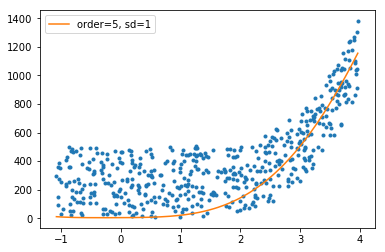

In [19]:
α_p_post = trace_p_q2a['α'].mean()
β_p_post = trace_p_q2a['β'].mean(axis=0)

idx = np.argsort(Xr[0])
y_p_post = α_p_post + np.dot(β_p_post, Xr)

plt.plot(Xr[0, idx], y_p_post[idx], 'C1', label=f'order={order}, sd=1')
plt.scatter(Xr[0, :], y, c='C0', marker='.')
plt.legend(loc="best")
_ = plt.show()

In [20]:
with pm.Model() as model_p_q2b:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=100, shape=5)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, Xr)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_p_q2b = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains: 100%|██████████| 10000/10000 [03:48<00:00, 43.84draws/s]
The acceptance probability does not match the target. It is 0.9548363411104669, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8907665308242607, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8979084758517007, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8890008203274021, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [21]:
az.summary(trace_p_q2b)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,1.82,1.01,0.01,-0.02,3.77,5037.0,1.0
β[0],118.32,21.19,0.56,75.89,155.55,1944.0,1.0
β[1],246.35,11.84,0.09,224.47,268.46,5004.0,1.0
β[2],-211.29,19.55,0.52,-247.16,-173.55,1755.0,1.0
β[3],58.12,9.73,0.26,39.99,76.28,1659.0,1.0
β[4],-4.44,1.34,0.03,-6.87,-1.88,1698.0,1.0
ϵ,122.35,2.07,0.02,118.35,126.13,5775.0,1.0


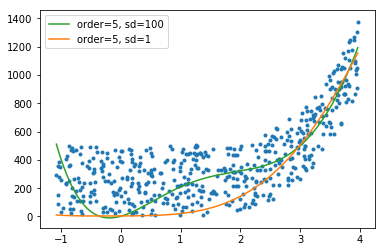

In [22]:
α_p_post = trace_p_q2b['α'].mean()
β_p_post = trace_p_q2b['β'].mean(axis=0)

idx = np.argsort(Xr[0])
y_p_sd100_post = α_p_post + np.dot(β_p_post, Xr)

plt.plot(Xr[0, idx], y_p_sd100_post[idx], 'C2', label=f'order={order}, sd=100')
plt.plot(Xr[0, idx], y_p_post[idx], 'C1', label=f'order={order}, sd=1')
plt.scatter(Xr[0, :], y, c='C0', marker='.')
plt.legend(loc="best")
_ = plt.show()

In [23]:
with pm.Model() as model_p_q2c:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=np.array([10, 0.1, 0.1, 0.1, 0.1]))
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, Xr)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_p_q2c = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains: 100%|██████████| 10000/10000 [03:51<00:00, 43.15draws/s] 
The acceptance probability does not match the target. It is 0.9961195897099431, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9782675145463913, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.998129716247264, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does n

In [24]:
az.summary(trace_p_q2c)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,5.10,5.85,2.18,-0.89,12.07,2.0,9.63
β,0.61,0.78,0.26,-0.75,1.11,2.0,31.23
ϵ,274.52,62.46,15.96,119.57,335.25,12.0,1.04


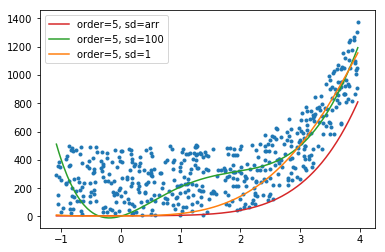

In [25]:
α_p_post = trace_p_q2c['α'].mean()
β_p_post = trace_p_q2c['β'].mean(axis=0)
β_p_post = np.array([β_p_post] * 5).T

idx = np.argsort(Xr[0])
y_p_arr_post = α_p_post + np.dot(β_p_post, Xr)

plt.plot(Xr[0, idx], y_p_arr_post[idx], 'C3', label=f'order={order}, sd=arr')
plt.plot(Xr[0, idx], y_p_sd100_post[idx], 'C2', label=f'order={order}, sd=100')
plt.plot(Xr[0, idx], y_p_post[idx], 'C1', label=f'order={order}, sd=1')
plt.scatter(Xr[0, :], y, c='C0', marker='.')
plt.legend(loc="best")
_ = plt.show()

100%|██████████| 200/200 [00:00<00:00, 1006.31it/s]


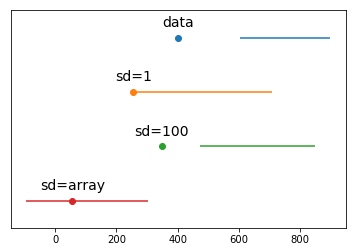

In [26]:
y_q2a_pps = pm.sample_posterior_predictive(trace_p_q2a, 200, model=model_p_q2a)['y_pred']
y_q2b_pps = pm.sample_posterior_predictive(trace_p_q2b, 200, model=model_p_q2b)['y_pred']
y_q2c_pps = pm.sample_posterior_predictive(trace_p_q2c, 200, model=model_p_q2c)['y_pred']

data = [y, y_q2a_pps, y_q2b_pps, y_q2c_pps]
labels = ['data', 'sd=1', 'sd=100', 'sd=array']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)

plt.ylim([-i-0.5, 0.5])
plt.yticks([])
_ = plt.show()

## Question 3

Fit a cubic model (order 3), compute WAIC and LOO, plot the results, and compare them with the linear and quadratic models.

In [27]:
def make_data(x, y, order):
    xp = np.vstack([x ** i for i in range(1, order+1)])
    xs = (xp - xp.mean(axis=1, keepdims=True)) / xp.std(axis=1, keepdims=True)
    ys = (y - y.mean()) / y.std()
    return xs, ys


dummy_data = np.loadtxt('../BAP/code/data/dummy.csv')
x = dummy_data[:, 0]
y = dummy_data[:, 1]
order = 3

X, y = make_data(x, y, order)
X.shape, y.shape

((3, 33), (33,))

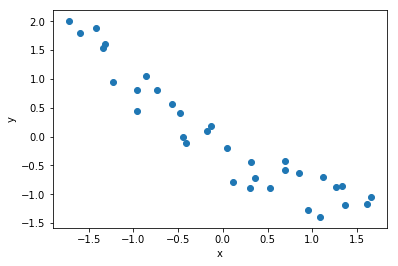

In [28]:
plt.scatter(X[0], y)
plt.xlabel('x')
plt.ylabel('y')
_ = plt.show()

In [29]:
with pm.Model() as model_p_q3a:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, X)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_p_q3a = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:11<00:00, 853.18draws/s]


In [30]:
order = 2
X2 = X[:-1, :]

with pm.Model() as model_p_q3b:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, X2)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_p_q3b = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:05<00:00, 1717.70draws/s]
The acceptance probability does not match the target. It is 0.8993241719613827, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8874808035965633, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8805697805999781, but should be close to 0.8. Try to increase the number of tuning steps.


In [31]:
order = 1
X1 = X[:-2, :]

with pm.Model() as model_p_q3c:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, X1)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    trace_p_q3c = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:03<00:00, 3021.94draws/s]


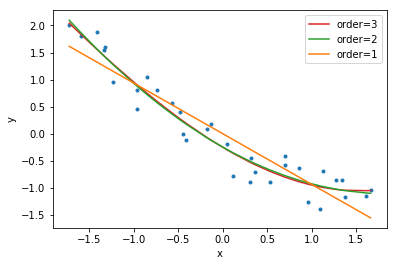

In [32]:
def compute_ypreds(trace, X):
    α_p_post = trace['α'].mean()
    β_p_post = trace['β'].mean(axis=0)
    ypred_post = α_p_post + np.dot(β_p_post, X)
    return ypred_post

ypred_post_o3 = compute_ypreds(trace_p_q3a, X)
ypred_post_o2 = compute_ypreds(trace_p_q3b, X2)
ypred_post_o1 = compute_ypreds(trace_p_q3c, X1)

idx = np.argsort(X[0])
plt.plot(X[0, idx], ypred_post_o3[idx], 'C3', label='order=3')
plt.plot(X[0, idx], ypred_post_o2[idx], 'C2', label='order=2')
plt.plot(X[0, idx], ypred_post_o1[idx], 'C1', label='order=1')
plt.scatter(X[0], y, marker='.')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="best")
_ = plt.show()

100%|██████████| 200/200 [00:00<00:00, 990.67it/s]


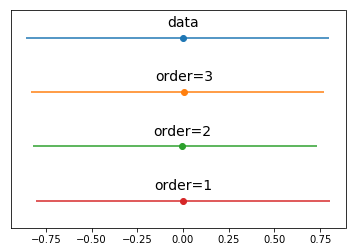

In [33]:
y_q3a_pps = pm.sample_posterior_predictive(trace_p_q3a, 200, model=model_p_q3a)['y_pred']
y_q3b_pps = pm.sample_posterior_predictive(trace_p_q3b, 200, model=model_p_q3b)['y_pred']
y_q3c_pps = pm.sample_posterior_predictive(trace_p_q3c, 200, model=model_p_q3c)['y_pred']

data = [y, y_q3a_pps, y_q3b_pps, y_q3c_pps]
labels = ['data', 'order=3', 'order=2', 'order=1']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)

plt.ylim([-i-0.5, 0.5])
plt.yticks([])
_ = plt.show()

In [34]:
cmp_df = az.compare({
    "model_cubic": trace_p_q3a,
    "model_quadratic": trace_p_q3b,
    "model_linear": trace_p_q3c
}, ic="loo")
cmp_df

,loo,ploo,dloo,weight,se,dse,warning
model_quadratic,9.12524,2.62895,0,1,4.78896,0,0
model_cubic,10.4222,3.12338,1.29697,2.72005e-15,4.76004,0.91205,0
model_linear,28.6678,2.39675,19.5425,6.66134e-16,5.30615,5.12436,0


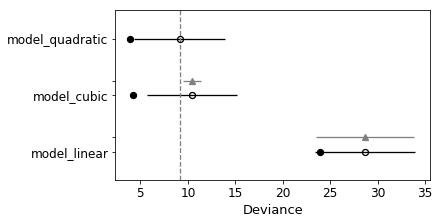

In [35]:
_ = az.plot_compare(cmp_df)

In [36]:
cmp_df = az.compare({
    "model_cubic": trace_p_q3a,
    "model_quadratic": trace_p_q3b,
    "model_linear": trace_p_q3c
}, ic="waic")
cmp_df

,waic,pwaic,dwaic,weight,se,dse,warning
model_quadratic,9.06938,2.60103,0,1,4.77962,0,0
model_cubic,10.3289,3.07674,1.25954,2.30371e-15,4.75132,0.905246,0
model_linear,28.6082,2.36698,19.5388,7.77156e-16,5.29259,5.11113,0


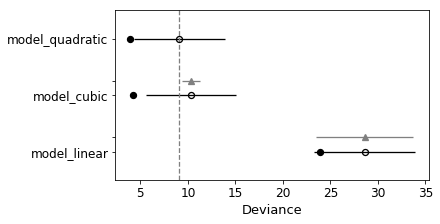

In [37]:
_ = az.plot_compare(cmp_df)

## Question 4

Use `pm.sample_posterior_predictive()` to rerun the PPC example, but this time, plot the values of y instead of the values of the mean.

In [38]:
dummy_data = np.loadtxt('../BAP/code/data/dummy.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]
order = 5

x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()

In [39]:
with pm.Model() as model_p_q4a:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, x_1s)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    trace_p_q4a = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:35<00:00, 278.64draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [40]:
ypred_pps = pm.sample_posterior_predictive(trace_p_q4a, 2000, model=model_p_q4a)["y_pred"]
ypred_pps.shape

100%|██████████| 2000/2000 [00:01<00:00, 1531.66it/s]


(2000, 33)

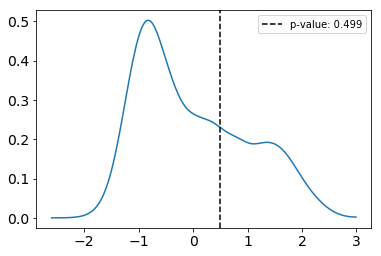

In [41]:
y_true = y.repeat(2000)
y_pred = ypred_pps.reshape(-1)
p_value = np.mean(y_pred > y_true)
az.plot_kde(y_pred)
plt.axvline(x=p_value, color="k", linestyle="dashed", label="p-value: {:.3f}".format(p_value))
plt.legend(loc="best")
_ = plt.show()

## Question 5

Go back to the code that generated Figure 5.5 and Figure 5.6, and modify it to get new sets of six data points. Visually evaluate how the different polynomials fit these new datasets. Relate the results to the discussions in this book.

<p><font color="blue">
    <p>In general, higher degree polynomials will fit the points better, but they tend to overfit, so the model is less able to predict new data points accurately.</p>
</font></p>

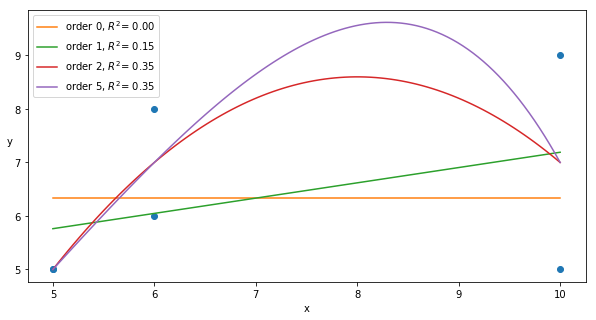

In [42]:
# x = np.array([4., 5., 6., 9., 12, 14.])
# y = np.array([4.2, 6., 6., 9., 10, 10.])

x = np.random.randint(low=4, high=14, size=6)
y = np.random.randint(low=4, high=10, size=6)

plt.figure(figsize=(10, 5))
order = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    r2 = ssreg / sstot
    plt.plot(x_n, ffit, label=f'order {i}, $R^2$= {r2:.2f}')
    
plt.legend(loc=2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
_ = plt.show()

## Question 7

Read and run the model averaging example from PyMC3's documentation at https://docs.pymc.io/notebooks/model_averaging.html.

<p><font color="blue"><p>Idea here is to do a az.compare with WAIC over multiple models and get back the weights, then predict using the weighted predictions from all models, using a call to pm.sample_posterior_predictive_w.</p></font></p>

## Question 8

Compute the Bayes factor for the coin problem using a uniform prior beta (1, 1) and priors such as beta (0.5, 0.5). Set 15 heads and 30 coins. Compare this result with the inference we got in the first chapter of this book.

<p><font color="blue"><p>The computed Bayes Factor of 1.5 indicates that Model with Beta priors (1, 1) is about 1.5 times more favored than Model with Beta priors (0.5, 0.5). However, comparing the models using WAIC shows that they are about on par with each other.</p></font></p>

In [43]:
coins, heads = 30, 15
y = np.repeat([0, 1], [coins - heads, heads])
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [44]:
with pm.Model() as model_BF_q8:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p=p)
    m_0 = (1, 1)
    m_1 = (0.5, 0.5)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)
    θ = pm.Beta('θ', m[0], m[1])
    y_pred = pm.Bernoulli('y_pred', θ, observed=y)
    trace_BF_q8 = pm.sample(5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model_index]
>NUTS: [θ]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:05<00:00, 3718.23draws/s]


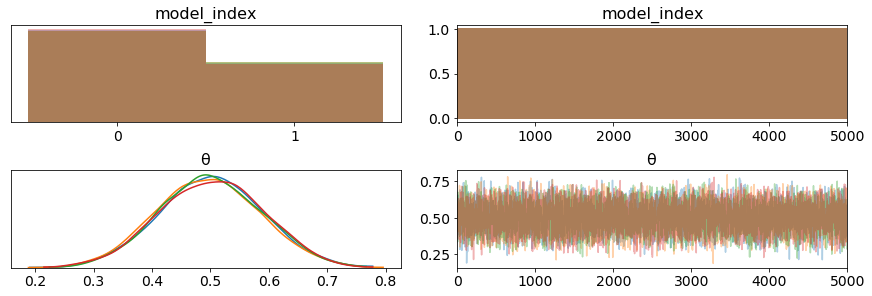

In [45]:
_ = az.plot_trace(trace_BF_q8)

In [46]:
pM1 = trace_BF_q8['model_index'].mean()
pM0 = 1 - pM1
BF = (pM0 / pM1) * (p[1] / p[0])
BF

1.5493945188017846

In [47]:
with pm.Model() as model_BF_q8a:
    θ = pm.Beta('θ', 1, 1)
    y_pred = pm.Bernoulli('y_pred', θ, observed=y)
    trace_BF_q8a = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:04<00:00, 4410.29draws/s]


In [48]:
with pm.Model() as model_BF_q8b:
    θ = pm.Beta('θ', 0.5, 0.5)
    y_pred = pm.Bernoulli('y_pred', θ, observed=y)
    trace_BF_q8b = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:05<00:00, 4029.60draws/s]
The acceptance probability does not match the target. It is 0.8806216557894032, but should be close to 0.8. Try to increase the number of tuning steps.


In [49]:
cmp_df = az.compare({
    "Beta(1,1) prior": trace_BF_q8a,
    "Beta(0.5, 0.5) prior": trace_BF_q8b
}, ic="waic")
cmp_df

,waic,pwaic,dwaic,weight,se,dse,warning
"Beta(1,1) prior",43.5689,0.990025,0,1,0.00875816,0,0
"Beta(0.5, 0.5) prior",43.6287,1.01985,0.0597706,2.22045e-16,0.0262619,0.03502,0


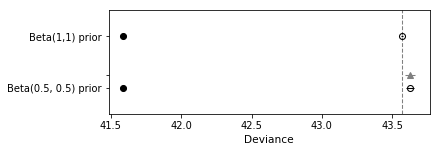

In [50]:
_ = az.plot_compare(cmp_df)

## Question 9

Repeat the last example where we compare Bayes factors and Information Criteria, but now reduce the sample size.

In [51]:
coins, heads = 10, 5
y = np.repeat([0, 1], [coins - heads, heads])
y

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [52]:
with pm.Model() as model_BF_q9:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p=p)
    m_0 = (1, 1)
    m_1 = (0.5, 0.5)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)
    θ = pm.Beta('θ', m[0], m[1])
    y_pred = pm.Bernoulli('y_pred', θ, observed=y)
    trace_BF_q9 = pm.sample(5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model_index]
>NUTS: [θ]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:06<00:00, 3405.55draws/s]


In [53]:
pM1 = trace_BF_q8['model_index'].mean()
pM0 = 1 - pM1
BF = (pM0 / pM1) * (p[1] / p[0])
BF

1.5493945188017846

In [54]:
with pm.Model() as model_BF_q9a:
    θ = pm.Beta('θ', 1, 1)
    y_pred = pm.Bernoulli('y_pred', θ, observed=y)
    trace_BF_q9a = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:05<00:00, 3783.02draws/s]


In [55]:
with pm.Model() as model_BF_q9b:
    θ = pm.Beta('θ', 0.5, 0.5)
    y_pred = pm.Bernoulli('y_pred', θ, observed=y)
    trace_BF_q9b = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:05<00:00, 4241.14draws/s]


In [56]:
cmp_df = az.compare({
    "Beta(1,1) prior": trace_BF_q9a,
    "Beta(0.5, 0.5) prior": trace_BF_q9b
}, ic="waic")
cmp_df

,waic,pwaic,dwaic,weight,se,dse,warning
"Beta(1,1) prior",15.757,0.946983,0,1,0.022923,0,0
"Beta(0.5, 0.5) prior",15.9602,1.04865,0.203293,0,0.00178609,0.0211369,0


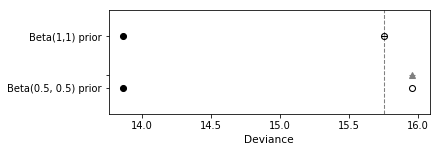

In [57]:
_ = az.plot_compare(cmp_df)

## Question 10

For the entropy example, change the q distribution. Try this with distributions like stats.binom(10, 0.5) and stats.binom(10, 0.25).

In [58]:
y = stats.binom(1, p=0.5).rvs(10)
y

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 1])

In [59]:
with pm.Model() as model_BF_q10a:
    θ = pm.Beta('θ', 1, 1)
    y_pred = pm.Bernoulli('y_pred', θ, observed=y)
    trace_BF_q9a = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:06<00:00, 3226.60draws/s]


In [60]:
with pm.Model() as model_BF_q10b:
    θ = pm.Beta('θ', 0.5, 0.5)
    y_pred = pm.Bernoulli('y_pred', θ, observed=y)
    trace_BF_q9b = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:05<00:00, 3706.52draws/s]


In [61]:
y = stats.binom(1, p=0.25).rvs(10)
y

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1])

In [62]:
with pm.Model() as model_BF_q10c:
    θ = pm.Beta('θ', 1, 1)
    y_pred = pm.Bernoulli('y_pred', θ, observed=y)
    trace_BF_q9c = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:06<00:00, 3219.06draws/s]


In [63]:
with pm.Model() as model_BF_q10d:
    θ = pm.Beta('θ', 0.5, 0.5)
    y_pred = pm.Bernoulli('y_pred', θ, observed=y)
    trace_BF_q9d = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:05<00:00, 3720.90draws/s]


In [64]:
cmp_df = az.compare({
    "model_1": trace_BF_q9a,
    "model_2": trace_BF_q9b,
    "model_3": trace_BF_q9c,
    "model_4": trace_BF_q9d
}, ic="waic")
cmp_df

,waic,pwaic,dwaic,weight,se,dse,warning
model_3,14.0809,0.906075,0,0.818914,2.43806,0,0
model_4,14.2958,1.03097,0.214824,7.45472e-17,2.73624,0.298178,0
model_1,15.3769,0.953842,1.29598,0.181086,1.28104,2.85336,0
model_2,15.5822,1.0598,1.50121,0,1.43187,2.93537,0


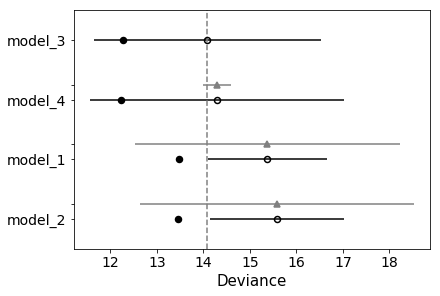

In [65]:
_ = az.plot_compare(cmp_df)